## COM4402 - Introducción a la Inteligencia Artificial
###*2do semestre del 2023*
# **Ayudantía 4:** Redes neuronales con PyTorch

*Nombre: Marisa Vidal Leiva*

> En este notebook veremos como podemos usar nuestras propias redes neuronales con PyTorch.

> Se utilizará como base el colab entregado por la ayudante Camila Rapu en esta tarea.

---
## Antes de ejecutar el código, activar el uso de GPU en Google Colab.

* Ir a "Entorno de Ejecución" en el menú superior
* Haga click en "Cambiar tipo de entorno de ejecución"
* Seleccionar "T4 GPU" en "Acelerador de Hardware"
---

---
# Clasificación de dígitos
---

El problema que veremos será la clasificación de dígitos, con el dataset *Optical Recognition of Handwritten Digits Data Set* que contiene imágenes de 8x8 pixeles con dígitos manuscritos. El objetivo es lograr reconocer a que dígito corresponde cada muestra o imágen.

# Subir archivos

Cargaremos el dataset de forma remota con `wget` desde un repositorio de GitHub. Así podremos acceder al dataset solo con ejecutar las siguientes lineas, ya que este descarga los archivos directamente en el ambiente de Colab.

In [ ]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt

--2023-10-28 19:54:30--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  3.78MB/s    in 0.2s    

2023-10-28 19:54:32 (3.78 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]



In [ ]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-28 19:57:26--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt’

1_digits_test.txt   100%[===================>] 183.20K  --.-KB/s    in 0.1s    

2023-10-28 19:57:27 (1.50 MB/s) - ‘1_digits_test.txt’ saved [187595/187595]



# Cargar dataset

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Cargar conjuntos de datos de entrenamiento y prueba
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_test = pd.read_csv('1_digits_test.txt', names = column_names)

> **Nota:** Con *head()* podemos ver las primeras 5 muestras o filas de un DataFrame.

In [ ]:
df_train_val.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [ ]:
df_test.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7


Vemos que tenemos 64 características más la columna de clases. Estas características corresponden a los pixeles que conforman las imágenes de 8x8, por ello el dataset tiene 64 dimensiones.

## Dividimos los datos de entrenamiento en validación y entrenamiento.

In [ ]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)
print("Muestras de entrenamiento: ", len(df_train))
print("Muestras de validación: ", len(df_val))
print("Muestras de prueba: ", len(df_test))
print("Muestras totales: ", len(df_train_val)+len(df_test))

Muestras de entrenamiento:  3042
Muestras de validación:  1305
Muestras de prueba:  1272
Muestras totales:  5619


## Normalización de los datos

In [ ]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])
df_train

<ipython-input-8-9e57453e69e1>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-8-9e57453e69e1>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-8-9e57453e69e1>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


# Dataloaders para utilizar los datos en PyTorch

In [ ]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [ ]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

# 1. Definición de modelo de red neuronal 10 neuronas en la capa oculta, usando funcion de activacion ReLU

In [54]:
# -- Modelo de una capa oculta con 10 neuronas y activación ReLU --
# Capa de entrada de 64 neuronas (porque hay 64 características)
# Capa oculta de 10 neuronas con activación ReLU
# Capa de salida de 10 neuronas (porque hay 10 clases)
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [55]:
# Se le indica a Pytorch que correremos el modelo con GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y optimizador usaremos
criterion = nn.CrossEntropyLoss()                         # Función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizador

Entrenamiento de la red
En el siguiente código entrenamos el modelo anterior por 1000 epocas, procesando cada batch o lote en el que los dataloaders particionaron los datos. A lo largo del entrenamiento, calculamos la perdida (loss) de la red para poder visualizar su rendimiento luego.

Epoch: 0, train loss: 2.3012, val loss: 2.2610
Epoch: 1, train loss: 2.2044, val loss: 2.1352
Epoch: 2, train loss: 2.0641, val loss: 1.9537
Epoch: 3, train loss: 1.8694, val loss: 1.7251
Epoch: 4, train loss: 1.6594, val loss: 1.5122
Epoch: 5, train loss: 1.4631, val loss: 1.3465
Epoch: 6, train loss: 1.2932, val loss: 1.1812
Epoch: 7, train loss: 1.1363, val loss: 1.0509
Epoch: 8, train loss: 0.9860, val loss: 0.8974
Epoch: 9, train loss: 0.8502, val loss: 0.7913
Epoch: 10, train loss: 0.7348, val loss: 0.6811
Epoch: 11, train loss: 0.6408, val loss: 0.5975
Epoch: 12, train loss: 0.5639, val loss: 0.5285
Epoch: 13, train loss: 0.5063, val loss: 0.4829
Epoch: 14, train loss: 0.4621, val loss: 0.4483
Epoch: 15, train loss: 0.4235, val loss: 0.4236
Epoch: 16, train loss: 0.3933, val loss: 0.3814
Epoch: 17, train loss: 0.3662, val loss: 0.3711
Epoch: 18, train loss: 0.3397, val loss: 0.3613
Epoch: 19, train loss: 0.3172, val loss: 0.3187
Epoch: 20, train loss: 0.2939, val loss: 0.3070
Ep

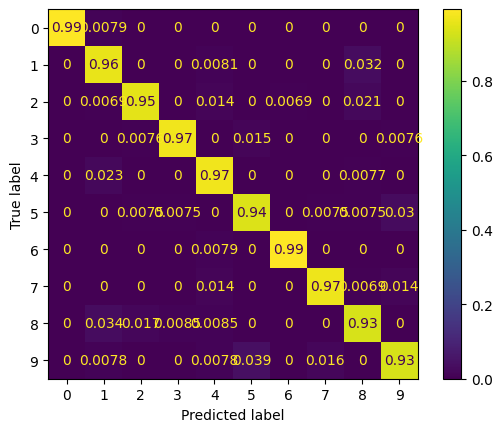

In [56]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []

last_loss = 100
tolerance = 4
count = 0

# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model.eval()

  true_labels = []  # Lista para almacenar las etiquetas verdaderas
  predicted_labels = []  # Lista para almacenar las etiquetas predichas
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model(inputs)              # Obtenemos predicciones

      # Guardar las etiquetas verdaderas y predichas
      true_labels.extend(labels.cpu().numpy())  # Convierte a NumPy para una fácil manipulación
      _, predicted = torch.max(outputs, 1)  # Obtener la etiqueta predicha
      predicted_labels.extend(predicted.cpu().numpy())

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if loss_val[epoch] > last_loss:
    count += 1
    print('Loss! cantidad de perdidas:',count)
    if(count >= tolerance):
      print('Early stopping! es hora de ver el modelo.')
      break
  else:
    count = 0
  last_loss = loss_val[epoch]

end = time.time()
matriz_confusion = confusion_matrix(true_labels, predicted_labels, normalize = "true")
print('Finished Training, total time %f seconds' % (end - start))
ConfusionMatrixDisplay(matriz_confusion).plot()

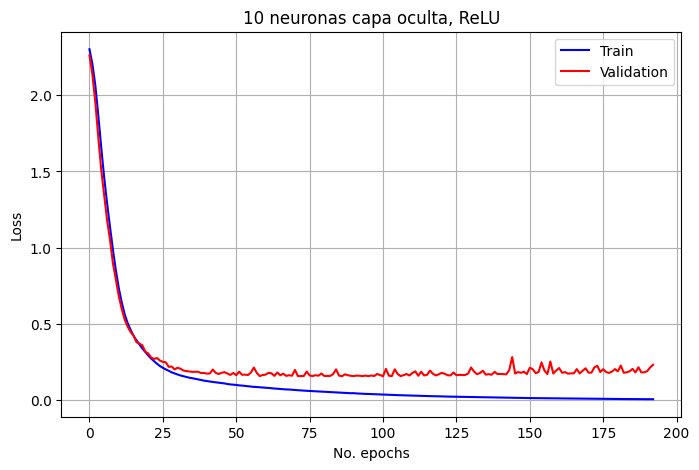

In [57]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('10 neuronas capa oculta, ReLU')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

# 2. Definición de modelo de red neuronal 40 neuronas en la capa oculta, usando funcion de activacion ReLU

In [58]:
# -- Modelo de una capa oculta con 10 neuronas y activación ReLU --
# Capa de entrada de 64 neuronas (porque hay 64 características)
# Capa oculta de 10 neuronas con activación ReLU
# Capa de salida de 10 neuronas (porque hay 10 clases)
model = nn.Sequential(
          nn.Linear(64, 40),
          nn.ReLU(),
          nn.Linear(40,40),
          nn.ReLU(),
          nn.Linear(40,10)
        )

In [59]:
# Se le indica a Pytorch que correremos el modelo con GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y optimizador usaremos
criterion = nn.CrossEntropyLoss()                         # Función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizador

Epoch: 0, train loss: 2.2006, val loss: 2.0564
Epoch: 1, train loss: 1.8256, val loss: 1.5393
Epoch: 2, train loss: 1.2392, val loss: 0.9302
Epoch: 3, train loss: 0.7349, val loss: 0.5835
Epoch: 4, train loss: 0.4297, val loss: 0.3491
Epoch: 5, train loss: 0.2746, val loss: 0.2331
Epoch: 6, train loss: 0.2026, val loss: 0.1862
Epoch: 7, train loss: 0.1640, val loss: 0.1700
Epoch: 8, train loss: 0.1381, val loss: 0.1507
Epoch: 9, train loss: 0.1184, val loss: 0.1359
Epoch: 10, train loss: 0.1038, val loss: 0.1241
Epoch: 11, train loss: 0.0923, val loss: 0.1140
Epoch: 12, train loss: 0.0830, val loss: 0.1105
Epoch: 13, train loss: 0.0755, val loss: 0.1111
Loss! cantidad de perdidas: 1
Epoch: 14, train loss: 0.0681, val loss: 0.1066
Epoch: 15, train loss: 0.0626, val loss: 0.0994
Epoch: 16, train loss: 0.0563, val loss: 0.0952
Epoch: 17, train loss: 0.0511, val loss: 0.0929
Epoch: 18, train loss: 0.0472, val loss: 0.0900
Epoch: 19, train loss: 0.0439, val loss: 0.0976
Loss! cantidad de pe

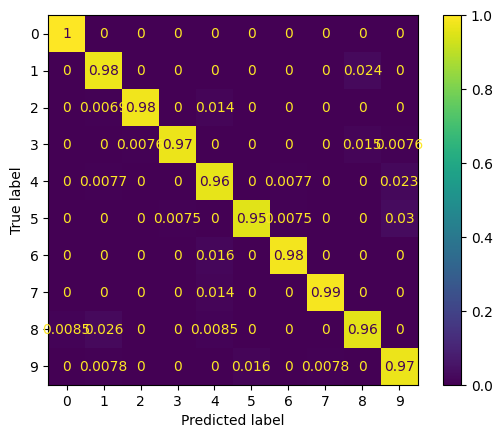

In [60]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []

last_loss = 100
tolerance = 4
count = 0

# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model.eval()

  true_labels = []  # Lista para almacenar las etiquetas verdaderas
  predicted_labels = []  # Lista para almacenar las etiquetas predichas
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model(inputs)              # Obtenemos predicciones

      # Guardar las etiquetas verdaderas y predichas
      true_labels.extend(labels.cpu().numpy())  # Convierte a NumPy para una fácil manipulación
      _, predicted = torch.max(outputs, 1)  # Obtener la etiqueta predicha
      predicted_labels.extend(predicted.cpu().numpy())

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if loss_val[epoch] > last_loss:
    count += 1
    print('Loss! cantidad de perdidas:',count)
    if(count >= tolerance):
      print('Early stopping! es hora de ver el modelo.')
      break
  else:
    count = 0
  last_loss = loss_val[epoch]

end = time.time()
matriz_confusion = confusion_matrix(true_labels, predicted_labels, normalize = "true")
print('Finished Training, total time %f seconds' % (end - start))
ConfusionMatrixDisplay(matriz_confusion).plot()

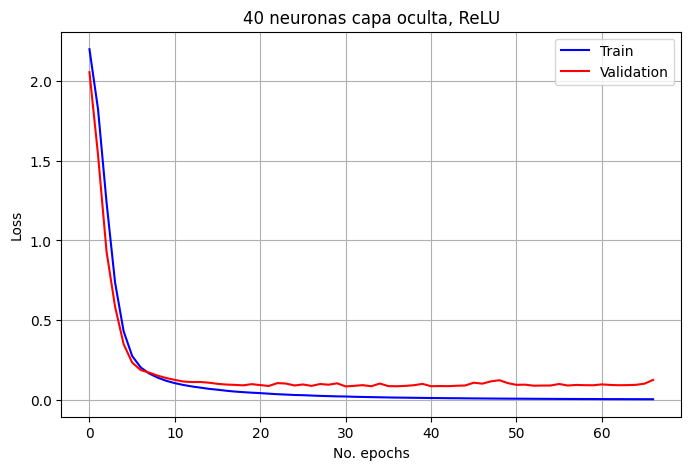

In [61]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('40 neuronas capa oculta, ReLU')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

# 3. Definición de modelo de red neuronal 10 neuronas en la capa oculta, usando funcion de activacion Tanh

In [62]:
# -- Modelo de una capa oculta con 10 neuronas y activación ReLU --
# Capa de entrada de 64 neuronas (porque hay 64 características)
# Capa oculta de 10 neuronas con activación ReLU
# Capa de salida de 10 neuronas (porque hay 10 clases)
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.Tanh(),
          nn.Linear(10,10),
          nn.Tanh(),
          nn.Linear(10,10)
        )

In [63]:
# Se le indica a Pytorch que correremos el modelo con GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y optimizador usaremos
criterion = nn.CrossEntropyLoss()                         # Función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizador

Epoch: 0, train loss: 2.2036, val loss: 2.1216
Epoch: 1, train loss: 2.0407, val loss: 1.9634
Epoch: 2, train loss: 1.8857, val loss: 1.8157
Epoch: 3, train loss: 1.7332, val loss: 1.6523
Epoch: 4, train loss: 1.5866, val loss: 1.5131
Epoch: 5, train loss: 1.4486, val loss: 1.3802
Epoch: 6, train loss: 1.3233, val loss: 1.2591
Epoch: 7, train loss: 1.2083, val loss: 1.1465
Epoch: 8, train loss: 1.1058, val loss: 1.0566
Epoch: 9, train loss: 1.0145, val loss: 0.9701
Epoch: 10, train loss: 0.9321, val loss: 0.8931
Epoch: 11, train loss: 0.8580, val loss: 0.8229
Epoch: 12, train loss: 0.7915, val loss: 0.7557
Epoch: 13, train loss: 0.7316, val loss: 0.7093
Epoch: 14, train loss: 0.6764, val loss: 0.6618
Epoch: 15, train loss: 0.6274, val loss: 0.6152
Epoch: 16, train loss: 0.5823, val loss: 0.5676
Epoch: 17, train loss: 0.5421, val loss: 0.5299
Epoch: 18, train loss: 0.5039, val loss: 0.4933
Epoch: 19, train loss: 0.4702, val loss: 0.4701
Epoch: 20, train loss: 0.4390, val loss: 0.4368
Ep

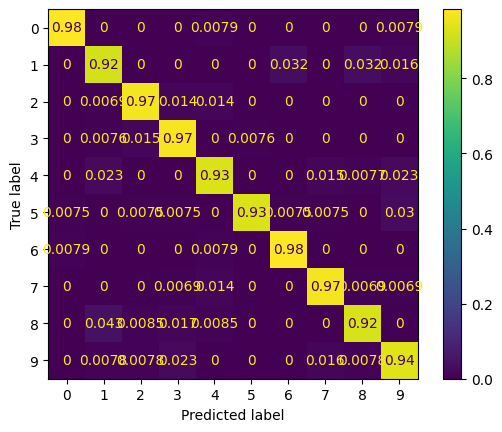

In [64]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []

last_loss = 100
tolerance = 4
count = 0

# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model.eval()

  true_labels = []  # Lista para almacenar las etiquetas verdaderas
  predicted_labels = []  # Lista para almacenar las etiquetas predichas
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model(inputs)              # Obtenemos predicciones

      # Guardar las etiquetas verdaderas y predichas
      true_labels.extend(labels.cpu().numpy())  # Convierte a NumPy para una fácil manipulación
      _, predicted = torch.max(outputs, 1)  # Obtener la etiqueta predicha
      predicted_labels.extend(predicted.cpu().numpy())

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if loss_val[epoch] > last_loss:
    count += 1
    print('Loss! cantidad de perdidas:',count)
    if(count >= tolerance):
      print('Early stopping! es hora de ver el modelo.')
      break
  else:
    count = 0
  last_loss = loss_val[epoch]

end = time.time()
matriz_confusion = confusion_matrix(true_labels, predicted_labels, normalize = "true")
print('Finished Training, total time %f seconds' % (end - start))
ConfusionMatrixDisplay(matriz_confusion).plot()

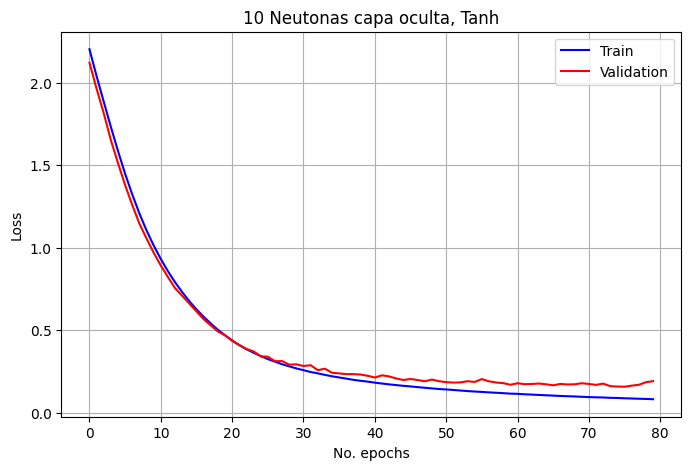

In [65]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('10 Neutonas capa oculta, Tanh')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

# 4. Definición de modelo de red neuronal 40 neuronas en la capa oculta, usando funcion de activacion Tanh

In [66]:
# -- Modelo de una capa oculta con 10 neuronas y activación ReLU --
# Capa de entrada de 64 neuronas (porque hay 64 características)
# Capa oculta de 10 neuronas con activación ReLU
# Capa de salida de 10 neuronas (porque hay 10 clases)
model = nn.Sequential(
          nn.Linear(64, 40),
          nn.Tanh(),
          nn.Linear(40,40),
          nn.Tanh(),
          nn.Linear(40,10)
        )

In [67]:
# Se le indica a Pytorch que correremos el modelo con GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y optimizador usaremos
criterion = nn.CrossEntropyLoss()                         # Función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizador

Epoch: 0, train loss: 2.0644, val loss: 1.7958
Epoch: 1, train loss: 1.5360, val loss: 1.2679
Epoch: 2, train loss: 1.0594, val loss: 0.8616
Epoch: 3, train loss: 0.7165, val loss: 0.5868
Epoch: 4, train loss: 0.5018, val loss: 0.4206
Epoch: 5, train loss: 0.3738, val loss: 0.3323
Epoch: 6, train loss: 0.2959, val loss: 0.2883
Epoch: 7, train loss: 0.2462, val loss: 0.2425
Epoch: 8, train loss: 0.2108, val loss: 0.2219
Epoch: 9, train loss: 0.1830, val loss: 0.1932
Epoch: 10, train loss: 0.1617, val loss: 0.1819
Epoch: 11, train loss: 0.1455, val loss: 0.1718
Epoch: 12, train loss: 0.1318, val loss: 0.1648
Epoch: 13, train loss: 0.1206, val loss: 0.1433
Epoch: 14, train loss: 0.1107, val loss: 0.1378
Epoch: 15, train loss: 0.1020, val loss: 0.1341
Epoch: 16, train loss: 0.0938, val loss: 0.1456
Loss! cantidad de perdidas: 1
Epoch: 17, train loss: 0.0866, val loss: 0.1261
Epoch: 18, train loss: 0.0804, val loss: 0.1253
Epoch: 19, train loss: 0.0746, val loss: 0.1169
Epoch: 20, train los

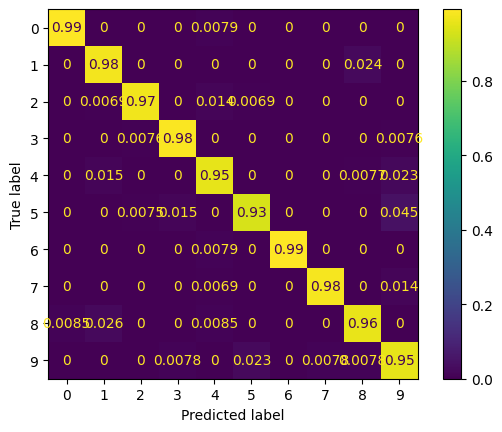

In [68]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []

last_loss = 100
tolerance = 4
count = 0

# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model.eval()

  true_labels = []  # Lista para almacenar las etiquetas verdaderas
  predicted_labels = []  # Lista para almacenar las etiquetas predichas
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model(inputs)              # Obtenemos predicciones

      # Guardar las etiquetas verdaderas y predichas
      true_labels.extend(labels.cpu().numpy())  # Convierte a NumPy para una fácil manipulación
      _, predicted = torch.max(outputs, 1)  # Obtener la etiqueta predicha
      predicted_labels.extend(predicted.cpu().numpy())

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if loss_val[epoch] > last_loss:
    count += 1
    print('Loss! cantidad de perdidas:',count)
    if(count >= tolerance):
      print('Early stopping! es hora de ver el modelo.')
      break
  else:
    count = 0
  last_loss = loss_val[epoch]

end = time.time()
matriz_confusion = confusion_matrix(true_labels, predicted_labels, normalize = "true")
print('Finished Training, total time %f seconds' % (end - start))
ConfusionMatrixDisplay(matriz_confusion).plot()

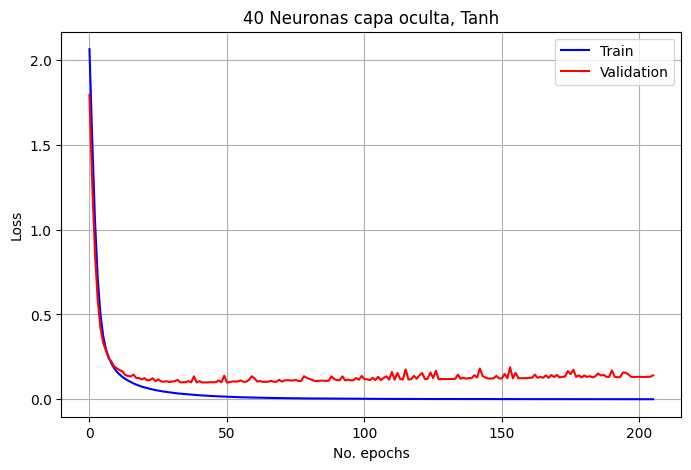

In [69]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('40 Neuronas capa oculta, Tanh')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

# 5. Definición de modelo de red neuronal dos capas ocultas de 10 neuronas usando ReLU

In [70]:
# -- Modelo de una capa oculta con 10 neuronas y activación ReLU --
# Capa de entrada de 64 neuronas (porque hay 64 características)
# Capa oculta de 10 neuronas con activación ReLU
# Capa de salida de 10 neuronas (porque hay 10 clases)
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10),
          nn.ReLU(),
          nn.Linear(10,10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [71]:
# Se le indica a Pytorch que correremos el modelo con GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y optimizador usaremos
criterion = nn.CrossEntropyLoss()                         # Función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizador

Epoch: 0, train loss: 2.2844, val loss: 2.2557
Epoch: 1, train loss: 2.2137, val loss: 2.1658
Epoch: 2, train loss: 2.0915, val loss: 2.0075
Epoch: 3, train loss: 1.9299, val loss: 1.8720
Epoch: 4, train loss: 1.7962, val loss: 1.7612
Epoch: 5, train loss: 1.6850, val loss: 1.6377
Epoch: 6, train loss: 1.5907, val loss: 1.5609
Epoch: 7, train loss: 1.5095, val loss: 1.4858
Epoch: 8, train loss: 1.4251, val loss: 1.3799
Epoch: 9, train loss: 1.3309, val loss: 1.2877
Epoch: 10, train loss: 1.2183, val loss: 1.1705
Epoch: 11, train loss: 1.0875, val loss: 1.0153
Epoch: 12, train loss: 0.9521, val loss: 0.9021
Epoch: 13, train loss: 0.8270, val loss: 0.7869
Epoch: 14, train loss: 0.7110, val loss: 0.6812
Epoch: 15, train loss: 0.6147, val loss: 0.5979
Epoch: 16, train loss: 0.5357, val loss: 0.5481
Epoch: 17, train loss: 0.4702, val loss: 0.4725
Epoch: 18, train loss: 0.4145, val loss: 0.4145
Epoch: 19, train loss: 0.3635, val loss: 0.3780
Epoch: 20, train loss: 0.3175, val loss: 0.3543
Ep

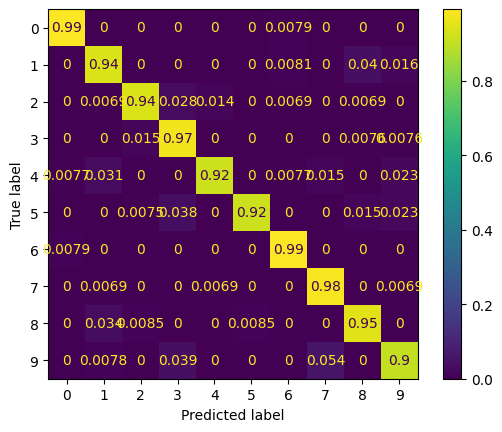

In [72]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []

last_loss = 100
tolerance = 4
count = 0

# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model.eval()

  true_labels = []  # Lista para almacenar las etiquetas verdaderas
  predicted_labels = []  # Lista para almacenar las etiquetas predichas
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model(inputs)              # Obtenemos predicciones

      # Guardar las etiquetas verdaderas y predichas
      true_labels.extend(labels.cpu().numpy())  # Convierte a NumPy para una fácil manipulación
      _, predicted = torch.max(outputs, 1)  # Obtener la etiqueta predicha
      predicted_labels.extend(predicted.cpu().numpy())

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if loss_val[epoch] > last_loss:
    count += 1
    print('Loss! cantidad de perdidas:',count)
    if(count >= tolerance):
      print('Early stopping! es hora de ver el modelo.')
      break
  else:
    count = 0
  last_loss = loss_val[epoch]

end = time.time()
matriz_confusion = confusion_matrix(true_labels, predicted_labels, normalize = "true")
print('Finished Training, total time %f seconds' % (end - start))
ConfusionMatrixDisplay(matriz_confusion).plot()

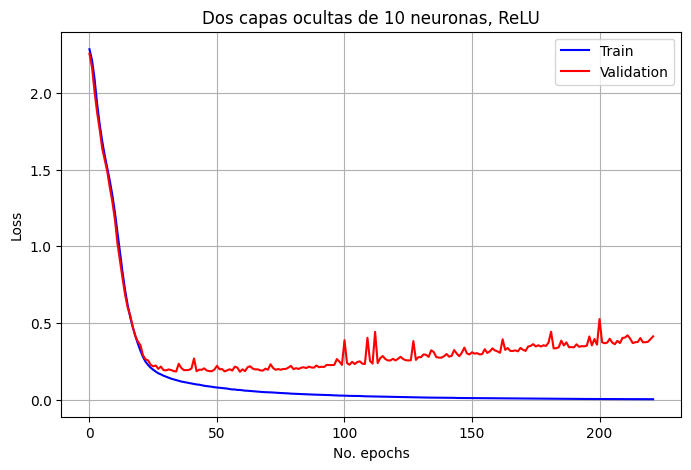

In [73]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Dos capas ocultas de 10 neuronas, ReLU')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

# 6. Definición de modelo de red neuronal dos capas ocultas de 40 neuronas usando ReLU

In [74]:
# -- Modelo de una capa oculta con 10 neuronas y activación ReLU --
# Capa de entrada de 64 neuronas (porque hay 64 características)
# Capa oculta de 10 neuronas con activación ReLU
# Capa de salida de 10 neuronas (porque hay 10 clases)
model = nn.Sequential(
          nn.Linear(64, 40),
          nn.ReLU(),
          nn.Linear(40,40),
          nn.ReLU(),
          nn.Linear(40,40),
          nn.ReLU(),
          nn.Linear(40,10)
        )

In [75]:
# Se le indica a Pytorch que correremos el modelo con GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y optimizador usaremos
criterion = nn.CrossEntropyLoss()                         # Función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizador

Epoch: 0, train loss: 2.2422, val loss: 2.1408
Epoch: 1, train loss: 1.9391, val loss: 1.6448
Epoch: 2, train loss: 1.3072, val loss: 0.9568
Epoch: 3, train loss: 0.7199, val loss: 0.4796
Epoch: 4, train loss: 0.3714, val loss: 0.2817
Epoch: 5, train loss: 0.2373, val loss: 0.2077
Epoch: 6, train loss: 0.1825, val loss: 0.1650
Epoch: 7, train loss: 0.1510, val loss: 0.1502
Epoch: 8, train loss: 0.1295, val loss: 0.1427
Epoch: 9, train loss: 0.1103, val loss: 0.1235
Epoch: 10, train loss: 0.0936, val loss: 0.1578
Loss! cantidad de perdidas: 1
Epoch: 11, train loss: 0.0838, val loss: 0.1289
Epoch: 12, train loss: 0.0715, val loss: 0.1034
Epoch: 13, train loss: 0.0643, val loss: 0.1094
Loss! cantidad de perdidas: 1
Epoch: 14, train loss: 0.0572, val loss: 0.0950
Epoch: 15, train loss: 0.0494, val loss: 0.0900
Epoch: 16, train loss: 0.0452, val loss: 0.0928
Loss! cantidad de perdidas: 1
Epoch: 17, train loss: 0.0403, val loss: 0.0884
Epoch: 18, train loss: 0.0369, val loss: 0.0891
Loss! ca

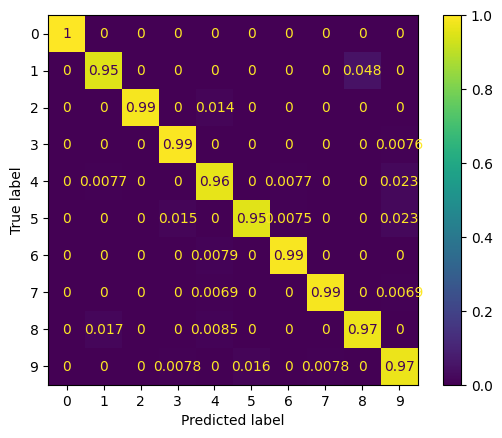

In [76]:
start = time.time()

# Guardar resultados del loss y epocas que duró el entrenamiento
loss_train = []
loss_val = []
epochs = []

last_loss = 100
tolerance = 4
count = 0

# Entrenamiento de la red por n epocas
for epoch in range(1000):

  # Guardar loss de cada batch
  loss_train_batches = []
  loss_val_batches = []

  # Entrenamiento --------------------------------------------------------------
  model.train()
  # Debemos recorrer cada batch (lote de los datos)
  for i, data in enumerate(dataloader_train, 0):
    # Procesar batch actual
    inputs = data["features"].to(device) # Características
    labels = data["labels"].to(device)   # Clases
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(inputs)           # Predicciones
    loss = criterion(outputs, labels) # Loss de entrenamiento
    loss.backward()                   # Backpropagation
    optimizer.step()

    # Guardamos la pérdida de entrenamiento en el batch actual
    loss_train_batches.append(loss.item())

  # Guardamos el loss de entrenamiento de la época actual
  loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

  # Predicción en conjunto de validación ---------------------------------------
  model.eval()

  true_labels = []  # Lista para almacenar las etiquetas verdaderas
  predicted_labels = []  # Lista para almacenar las etiquetas predichas
  with torch.no_grad():
    # Iteramos dataloader_val para evaluar el modelo en los datos de validación
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model(inputs)              # Obtenemos predicciones

      # Guardar las etiquetas verdaderas y predichas
      true_labels.extend(labels.cpu().numpy())  # Convierte a NumPy para una fácil manipulación
      _, predicted = torch.max(outputs, 1)  # Obtener la etiqueta predicha
      predicted_labels.extend(predicted.cpu().numpy())

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

  # Guardamos la época
  epochs.append(epoch)

  # Imprimir la pérdida de entrenamiento/validación en la época actual
  print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))

  # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
  if loss_val[epoch] > last_loss:
    count += 1
    print('Loss! cantidad de perdidas:',count)
    if(count >= tolerance):
      print('Early stopping! es hora de ver el modelo.')
      break
  else:
    count = 0
  last_loss = loss_val[epoch]

end = time.time()
matriz_confusion = confusion_matrix(true_labels, predicted_labels, normalize = "true")
print('Finished Training, total time %f seconds' % (end - start))
ConfusionMatrixDisplay(matriz_confusion).plot()

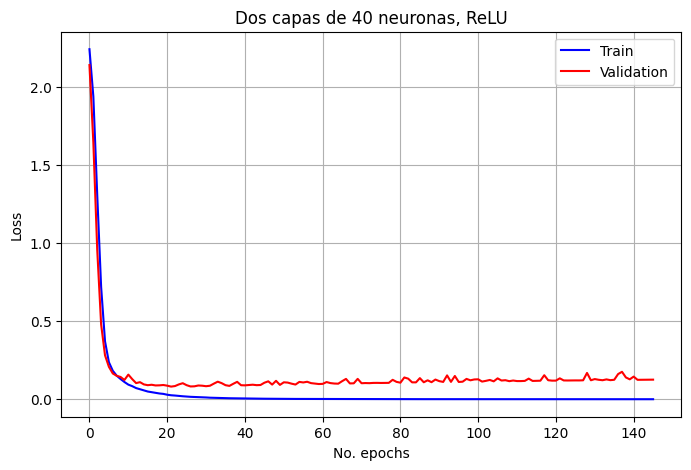

In [77]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Dos capas de 40 neuronas, ReLU')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()